In [1]:
import numpy as np   # scientific computing library
import tensorflow as tf  # library to implement ML
import matplotlib.pyplot as plt # to plot graphs
from PIL import Image

In [2]:
print 'Library versions used.'
print 'Numpy :{} \nTensorflow :{}'.format(np.version.version, tf.__version__)

Library versions used.
Numpy :1.13.1 
Tensorflow :1.2.1


In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
#Generator
z_size = 100
g_weight_size = 400
g_output_size = 28*28

In [5]:
#Discriminator
x_size = 28*28
d_weight_size = 400
d_output_size = 1

batch_size = 128

In [6]:
class Generator(object):
    def __init__(self, name='generator'):
        with tf.name_scope(name):
            self.name = name
            self.w = tf.Variable(tf.random_normal(shape=(z_size, g_weight_size)), name='w_in')
            self.b = tf.Variable(tf.zeros(shape=[g_weight_size]), name='b_in')
            self.w_out = tf.Variable(tf.random_normal(shape=(g_weight_size, g_output_size)), name='w_out')
            self.b_out = tf.Variable(tf.zeros(shape=[g_output_size]), name='b_out')
            
            tf.summary.histogram('weights', self.w)
            tf.summary.histogram('biases', self.b)
            tf.summary.histogram('weights_out', self.w_out)
            tf.summary.histogram('biases_out', self.b_out)
            
            self.params = [self.w, self.b, self.w_out, self.b_out]
    def generate(self,z):
        with tf.name_scope(self.name):
            h1 = tf.tanh(tf.matmul(z, self.w)+ self.b)
            output = tf.sigmoid(tf.matmul(h1, self.w_out)+ self.b_out)        
            return output

In [7]:
class Discriminator(object):
    def __init__(self, name='discriminator'):
        with tf.name_scope(name):
            self.w = tf.Variable(tf.random_normal(shape=(x_size, d_weight_size)), name='w')
            self.b = tf.Variable(tf.zeros(shape=[d_weight_size]), name='b')
            self.w_out = tf.Variable(tf.random_normal(shape=(d_weight_size, d_output_size)), name='w_out')
            self.b_out = tf.Variable(tf.zeros(shape=[d_output_size]), name='b_out')

            tf.summary.histogram('weights', self.w)
            tf.summary.histogram('biases', self.b)
            tf.summary.histogram('weights_out', self.w_out)
            tf.summary.histogram('biases_out', self.b_out)
            self.params = [self.w, self.b, self.w_out, self.b_out]
    def discriminate(self,x):
        with tf.name_scope(self.name):
            h1 = tf.tanh(tf.matmul(x, self.w) + self.b)
            output = tf.matmul(h1, self.w_out) + self.b_out
            return output

In [8]:
def generate_z(n=1):
    return np.random.normal(size=(n, z_size)).astype('float32')

In [9]:
z = tf.placeholder('float', shape=(None, z_size))
z1 = tf.placeholder('float', shape=(None, z_size))

X = tf.placeholder('float', shape=(None, x_size))

In [10]:
g = Generator()
d = Discriminator()

g_out_sample = g.generate(z1)
g_out = g.generate(z)
d_out_fake = d.discriminate(g_out)
d_out_real = d.discriminate(X)

with tf.name_scope('cost'):
    G_objective = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_out_fake, labels=tf.ones_like(d_out_fake)))
    
    d_obj_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_out_real, labels=(tf.ones_like(d_out_real)-0.1)))
    d_obj_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_out_fake, labels=tf.zeros_like(d_out_fake))) 
    D_objective = d_obj_real + d_obj_fake
    
    tf.summary.scalar('G_objective', G_objective)
    tf.summary.scalar('D_objective', D_objective)
    tf.summary.scalar('d_obj_real', d_obj_real)
    tf.summary.scalar('d_obj_fake', d_obj_fake)

In [11]:
inpt = tf.reshape(g_out_sample, shape = [-1, 28, 28, 1])
tf.summary.image('Generated_images', inpt, 9)

<tf.Tensor 'Generated_images:0' shape=() dtype=string>

In [12]:
G_opt = tf.train.AdamOptimizer().minimize(G_objective, var_list = g.params)
D_opt = tf.train.AdamOptimizer().minimize(D_objective, var_list = d.params)

In [13]:
LOGDIR = '/tmp/mnist/'
session = tf.Session()
session.run(tf.global_variables_initializer())
merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter(LOGDIR)
writer.add_graph(session.graph)

In [14]:
print 'Training Started.'
for i in range(50000):
#     session.run(G_opt, feed_dict={
#         z: generate_z(batch_size),
#     })
    session.run([G_opt, D_opt], feed_dict={
        X: data.train.images[np.random.choice(range(len(data.train.images)), batch_size)].reshape(batch_size, x_size),
        z: generate_z(batch_size),
    })
    if i% 100 ==0:
#         print i
        s = session.run(merged_summary,feed_dict={
                X: data.train.images[np.random.choice(range(len(data.train.images)), batch_size)].reshape(batch_size, x_size),
                z: generate_z(batch_size),
                z1 : generate_z(9),
        })
    writer.add_summary(s, i)
print 'Training Completed.'

Training Started.
Training Completed.


In [17]:
print('Run `tensorboard --logdir=%s` in terminal and see the results in tensorboard.' % LOGDIR)

Run `tensorboard --logdir=/tmp/mnist/` in terminal and see the results in tensorboard.


In [15]:
def plot_image(images):  # we pass the images and the corresponding labels to the function to plot
    
    fig, axes = plt.subplots(3, 3)  #create a subplots in 3 rows and 3 colums since we plot for 9 images
    fig.subplots_adjust(hspace=0.3, wspace=0.3) # provide spacing between the subplots
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(28,28), cmap='binary') # plot the i_th image
        
        # Remove the ticks in the axes
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

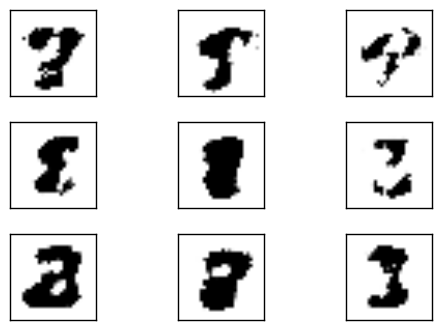

In [16]:
images = session.run(g_out_sample, feed_dict={z1:generate_z(9)})
plot_image(images)